# Open Wifi Networks in Low-Income Housing Projects
### Author_: Christian Rosado

In [1]:
# imports
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from fiona.crs import from_epsg
import shapely as shp
import seaborn 
import os
import geopandas as gpd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [66]:
# Original Data - filtered - device "VS425" only
original_data = pd.read_csv("../Downloads/original_data.csv", converters={"lng":float, "lat":float})
original_data.head()

,﻿freq,level,altitude,idx,caps,bssid,ssid,device_model,droid_version,app_version,device_mac,time,acc,lng,lat
0,2437,-79,0,56771877,[wpa-psk-ccmp+tkip][wpa2-psk-ccmp+tkip][wps][...,70:62:b8:46:29:06,462902,VS425,5.1.1,0.3.3,d3a2898a5e731607,1.497490e+12,39.360,-73.940196,40.695837
1,2447,-87,0,56765714,[wpa-psk-ccmp+tkip][wpa2-psk-ccmp+tkip][wps][...,48:ee:0c:50:23:8a,502386,VS425,5.1.1,0.3.3,d3a2898a5e731607,1.497480e+12,22.663,-73.939782,40.695816
2,2447,-78,-9,56765759,[wpa-psk-ccmp+tkip][wpa2-psk-ccmp+tkip][wps][...,48:ee:0c:50:23:8a,502386,VS425,5.1.1,0.3.3,d3a2898a5e731607,1.497480e+12,22.199,-73.939702,40.695853
3,2447,-74,0,56765816,[wpa-psk-ccmp+tkip][wpa2-psk-ccmp+tkip][wps][...,48:ee:0c:50:23:8a,502386,VS425,5.1.1,0.3.3,d3a2898a5e731607,1.497480e+12,21.769,-73.939759,40.695813
4,2447,-74,-8,56765893,[wpa-psk-ccmp+tkip][wpa2-psk-ccmp+tkip][wps][...,48:ee:0c:50:23:8a,502386,VS425,5.1.1,0.3.3,d3a2898a5e731607,1.497480e+12,20.083,-73.939599,40.696157


In [3]:
shape_path = "../Downloads/NYCHA_GIS_file/geo_export_e22c2615-1bfd-427d-8d52-369d3d187c5e.shp"
housing_projects = GeoDataFrame.from_file(shape_path)

In [4]:
from fiona.crs import from_epsg
#housing_projects.crs = from_epsg(4326)
#housing_projects.to_crs(epsg=4326)
housing_projects.crs

{'init': 'epsg:4326'}

In [ ]:
housing_projects[housing_projects.developmen == "SUMNER"].plot()

In [ ]:
housing_projects[housing_projects.developmen.str.contains("ROOSEVELT I")].plot()

In [ ]:
housing_projects[housing_projects.developmen.str.contains("303 VERNON AVENUE")].plot()

In [ ]:
housing_projects[housing_projects.developmen.str.contains("TOMPKINS")].plot()

In [60]:
housing_projects[housing_projects.tds_num.str.contains("131")]

,borough,developmen,geometry,tds_num
59,BROOKLYN,TOMPKINS,"POLYGON ((-73.9439942873495 40.69791332831738,...",131


In [73]:
#original_data["geometry"] = "POINT (" + original_data.lng + " " + original_data.lat + ")"
original_data["geometry"] = " "

In [78]:
for n, p in enumerate(zip(original_data.lng, original_data.lat)):
    original_data["geometry"].iloc[n] = shp.geometry.Point(p)

/Applications/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [176]:
wifi_data = GeoDataFrame(original_data)

In [93]:
wifi_data.crs = housing_projects.crs #matching crs of the two geodataframes
bklyn_housing = gpd.sjoin(wifi_data, housing_projects, how="inner", op='intersects') #geo merger

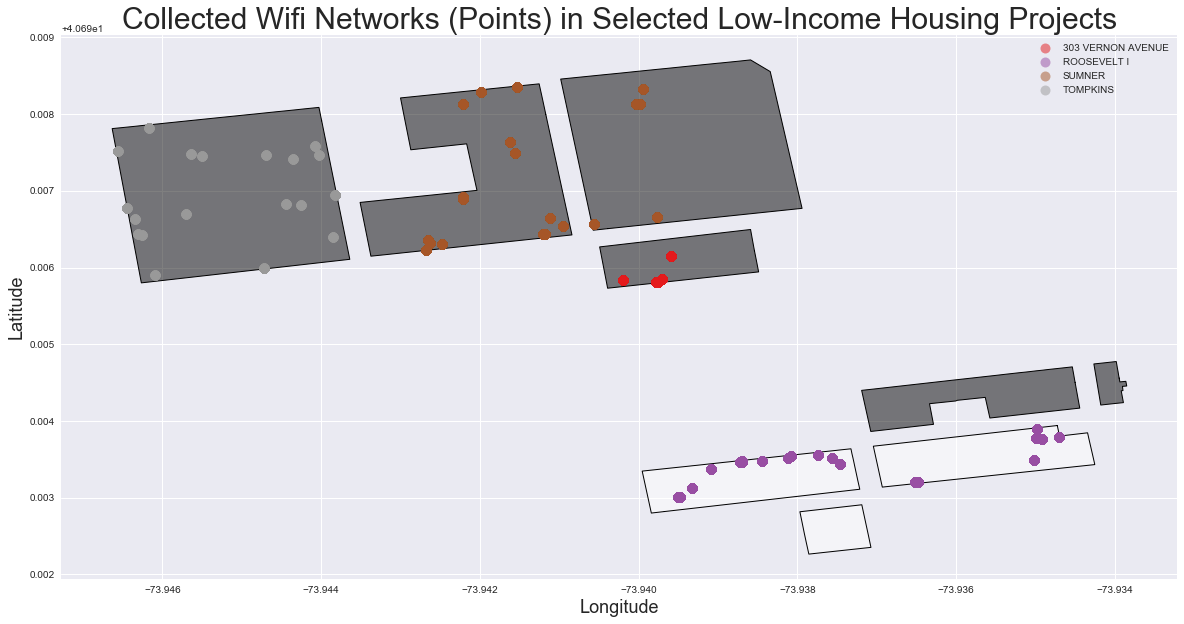

In [212]:
# non-open networks map
f,ax = pl.subplots(figsize=(20,10))
housing_projects[housing_projects.developmen == "SUMNER"].plot(ax=ax)
housing_projects[housing_projects.developmen.str.contains("ROOSEVELT I")].plot(ax=ax)
housing_projects[housing_projects.developmen.str.contains("303 VERNON AVENUE")].plot(ax=ax)
housing_projects[housing_projects.developmen.str.contains("TOMPKINS")].plot(ax=ax)
bklyn_housing.plot(column='developmen', markersize=10, ax=ax, legend=True)
plt.title("Collected Wifi Networks (Points) in Selected Low-Income Housing Projects", fontsize=30)
ax.set_ylabel('Latitude', fontsize=18)
ax.set_xlabel("Longitude", fontsize=18)

# Non-open Networks

In [134]:
# Non-open networks median levels by housing projects
bklyn_housing.pivot_table(columns="developmen", aggfunc=median, values="level")

developmen
303 VERNON AVENUE   -77
ROOSEVELT I         -76
SUMNER              -76
TOMPKINS            -75
Name: level, dtype: int64

In [179]:
# Wifi density
# Unique non-open networks by housing projects
density = bklyn_housing.groupby([bklyn_housing.developmen])['ssid'].nunique()
density

developmen
303 VERNON AVENUE    113
ROOSEVELT I          283
SUMNER               334
TOMPKINS             314
Name: ssid, dtype: int64

In [180]:
# Scans by ssid
scans_ssid = bklyn_housing.groupby([bklyn_housing.developmen, bklyn_housing.ssid])['level'].count()

In [181]:
scans_ssid = scans_ssid.unstack(fill_value=0)
scans_ssid.head()

ssid,023ee4,02426e,025a11,03b0f0,043029_guest,049b91,054fb0,05c9ce,0717ac,07ca0e,...,684900,7.64E+03,7.86E+03,745840,752820,797240,851682,929040,990800,993500
developmen,,,,,,,,,,,,,,,,,,,,,
303 VERNON AVENUE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ROOSEVELT I,0,0,0,0,0,0,0,0,5,0,...,0,0,0,0,5,0,2,6,7,0
SUMNER,0,5,0,2,0,0,0,0,0,0,...,0,6,0,2,0,1,0,0,0,0
TOMPKINS,1,0,7,0,1,2,2,1,0,1,...,2,0,2,0,0,0,0,0,0,2


In [133]:
# Non-open networks median levels by ssid and housing project
bklyn_housing.pivot_table(columns="developmen", aggfunc=median, values="level", index="ssid")

developmen,303 VERNON AVENUE,ROOSEVELT I,SUMNER,TOMPKINS
ssid,,,,
023ee4,NaN,NaN,NaN,-73.0
02426e,NaN,NaN,-76.0,NaN
025a11,NaN,NaN,NaN,-76.0
03b0f0,NaN,NaN,-86.0,NaN
043029_guest,NaN,NaN,NaN,-79.0
049b91,NaN,NaN,NaN,-75.0
054fb0,NaN,NaN,NaN,-67.0
05c9ce,NaN,NaN,NaN,-78.0
0717ac,NaN,-75.0,NaN,NaN


# Open Networks

* flatiron free wifi
* freewifibysurface
* bryantpark.org
* DowntownBrooklynWiFi_Fon
* linknyc free wi-fi
* Metrotech
* usp park wifi
* Red Hook Wifi

In [203]:
def open_net(x):
    if "flatiron free wifi" in x:
        return True
    else:
        if "freewifibysurface" in x:
            return True
        else:
            if "freewifibysurface" in x:
                return True
            else:
                if "bryantpark.org" in x:
                    return True
                else:
                    if "DowntownBrooklynWiFi_Fon" in x:
                        return True
                    else:
                        if "linknyc free wi-fi" in x:
                            return True
                        else:
                            if "Metrotech" in x:
                                return True
                            else:
                                if "usp park wifi" in x:
                                    return True
                                else: 
                                    if "Red Hook Wifi" in x:
                                        return True
                                    else:
                                        return False

In [204]:
bklyn_housing["open_net"] = open_net(bklyn_housing.ssid)

# No Open Networks - in selected low-income housing projects

In [209]:
# Open networks median levels by housing projects
bklyn_housing[bklyn_housing.open_net == True].pivot_table(columns="developmen", aggfunc=median, values="level")

developmen
level


# Some History on Targeted Housing Projects

# http://www.complex.com/pop-culture/2013/09/which-nyc-housing-projects-have-produced-the-most-famous-people/walt-whitman-houses